# ST590 Project3-Group16
### Student: Autumn Biggie and YiHua Lin


## Introduction: 

The S&P 500 is a capitalization-weighted index of the top 500 publicly traded companies in the United States (top 500 meaning the companies with the largest market cap). The S&P 500 index is a useful index to study because it generally reflects the health of the overall U.S. stock market.

We are going to use S&P 500 Financial Dataset to predict price and to determine the high-quality company

## Predictor Introduction( 4 character variables and 10 numeric variables): 

character variables:

**Symbol-** Ticker symbol used to uniquely identify each company on a particular stock market

**Name-** Legal name of the company

**Sector-** An area of the economy where businesses share a related product or service

**SEC Filings-** Helpful documents relating to a company

numeric variables:

**Price/Earnings(P/E)-** financial indicator equal to the ratio of the market value of a share to the annual earnings per share

**Dividend yield-** the ratio of the annual dividend per share to the share price. This value is most often expressed as a percentage.

**Earnings/Share(EPS) -** financial indicator equal to the ratio of the company's net profit available for distribution to the average annual number of ordinary shares.

**EBITDA-** an analytical indicator equal to the amount of profit before deduction of expenses on payment of interest, taxes, depreciation and amortization.Often used as a proxy for its profitability

**Price/Sales(P/S)-** financial indicator equal to the ratio of a company's market capitalization to its annual revenue.

**Price/book(P/B)-** financial ratio equal to the ratio of the company's current market capitalization to its book value.

**Price-** Price per share of the company

**52 week high-** The annual high of a company’s share price

**52 week low-** The annual low of a company’s share price
        - 
        
**Market Cap-** The market value of a company’s shares (calculated as share price x number of shares)


## Exploratory Data Analysis  

In the first section of this document, we'll perform EDA on the data. Specifically, we will only work with the training data during this portion, and explore trends using numerical summaries and plots. The response variable in questions is `Price`, so this will be the focus of our EDA.  

### Import appropriate modules for starting spark session, using pandas on spark, and accessing math functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import scipy.stats as stats
import sqlite3
import pylab as pl
#import plotly
import pyspark.pandas as ps
#import plotly.graph_objs as go
import seaborn as sns
import sys
import os
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
#from plotly.offline import init_notebook_mode, iplot
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import isnan, when, count, col
spark = SparkSession.builder.master('local[*]').appName('my-app').getOrCreate()
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.tree import RandomForest
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


### Data Split and Cleaning    

First we need to read in the `financials.csv` data set from Kaggle.com. The first 5 observations are displayed below.  

In [2]:
# Read in S&P 500 data set using pandas
financials = pd.read_csv("financials.csv") 
financials.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


We create dummy variables for each category in the variable `Sector` for ease of use when modeling.  The resulting data set is shown below.  

In [3]:
#Dummy variable-sector
financialsj=pd.get_dummies(financials["Sector"])
#join dummy dataframe to pandas dataframe
financials=financials.join(financialsj)
financials.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,...,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunication Services,Utilities
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,...,0,0,0,0,1,0,0,0,0,0
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,...,0,0,0,0,1,0,0,0,0,0
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,...,0,0,0,1,0,0,0,0,0,0
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,...,0,0,0,1,0,0,0,0,0,0
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,...,0,0,0,0,0,1,0,0,0,0


Now we convert the pandas data frame `financials` to a `spark` data frame called `findata`.  

In [4]:
findata = spark.createDataFrame(financials) #convert to spark data frame
findata.show()

+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+----------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|Symbol|                Name|              Sector| Price|Price/Earnings|Dividend Yield|Earnings/Share|52 Week Low|52 Week High|     Market Cap|    EBITDA|Price/Sales|Price/Book|         SEC Filings|Consumer Discretionary|Consumer Staples|Energy|Financials|Health Care|Industrials|Information Technology|Materials|Real Estate|Telecommunication Services|Utilities|
+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+----------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+------

Before we perform any Exploratory Data Analysis (EDA), we need to split the data set and only work with the training data. This will ensure we are exploring the data and building models without looking at the test data. Hopefully, this will ultimately help us produce a model that performs well on new data, not just the data we currently have access to.  

The following code splits the data into two spark data frames, `train` and `test`. The pandas-on-spark versions of these data frames are called `fintrain` and `fintest`.  

In [5]:
#split pandas dataframe then transfer train and test set to spark
# Create training and test set with 80%/20% split, returning #obs in each set
# We will use THESE sets during modeling
train, test = findata.randomSplit([0.8, 0.2], seed = 3)
print(train.count(), test.count())
# Convert training set above to pandas-on-spark data set 
fintrain = train.to_pandas_on_spark()
fintest = test.to_pandas_on_spark()

398 107


There are 398 observations in the training set and 107 observations in the test set. Now let's check out the schema of the train data set so we can determine which variables to explore.  

In [8]:
# check the columns ( pysqldataframe)
train.printSchema()
train.describe()

root
 |-- Symbol: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Price/Earnings: double (nullable = true)
 |-- Dividend Yield: double (nullable = true)
 |-- Earnings/Share: double (nullable = true)
 |-- 52 Week Low: double (nullable = true)
 |-- 52 Week High: double (nullable = true)
 |-- Market Cap: double (nullable = true)
 |-- EBITDA: double (nullable = true)
 |-- Price/Sales: double (nullable = true)
 |-- Price/Book: double (nullable = true)
 |-- SEC Filings: string (nullable = true)
 |-- Consumer Discretionary: long (nullable = true)
 |-- Consumer Staples: long (nullable = true)
 |-- Energy: long (nullable = true)
 |-- Financials: long (nullable = true)
 |-- Health Care: long (nullable = true)
 |-- Industrials: long (nullable = true)
 |-- Information Technology: long (nullable = true)
 |-- Materials: long (nullable = true)
 |-- Real Estate: long (nullable = true)
 |-- Telecommunication Se

DataFrame[summary: string, Symbol: string, Name: string, Sector: string, Price: string, Price/Earnings: string, Dividend Yield: string, Earnings/Share: string, 52 Week Low: string, 52 Week High: string, Market Cap: string, EBITDA: string, Price/Sales: string, Price/Book: string, SEC Filings: string, Consumer Discretionary: string, Consumer Staples: string, Energy: string, Financials: string, Health Care: string, Industrials: string, Information Technology: string, Materials: string, Real Estate: string, Telecommunication Services: string, Utilities: string]

We need to check for any missing values that could cause problems during our analysis, then remove them from the data.  

In [9]:
#checking for null values( pysqldataframe)
train.select([count(when(isnan(c), c)).alias(c) for c in train.columns]).show()

+------+----+------+-----+--------------+--------------+--------------+-----------+------------+----------+------+-----------+----------+-----------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|Symbol|Name|Sector|Price|Price/Earnings|Dividend Yield|Earnings/Share|52 Week Low|52 Week High|Market Cap|EBITDA|Price/Sales|Price/Book|SEC Filings|Consumer Discretionary|Consumer Staples|Energy|Financials|Health Care|Industrials|Information Technology|Materials|Real Estate|Telecommunication Services|Utilities|
+------+----+------+-----+--------------+--------------+--------------+-----------+------------+----------+------+-----------+----------+-----------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|     0|   0|     0|    0|             2|             0|  

In [6]:
#remove the missing data

train=train.na.drop()
test = test.na.drop()

In addition, there are special characters such as slashes and spaces that could also cause problems, so we'll replace all of them with underscores.  

In [7]:
#change the column name for easier EDA
train = train.select([func.col(col).alias(col.replace('/', '_')) for col in train.columns])
train = train.select([func.col(col).alias(col.replace(' ', '_')) for col in train.columns])

test = test.select([func.col(col).alias(col.replace('/', '_')) for col in test.columns])
test = test.select([func.col(col).alias(col.replace(' ', '_')) for col in test.columns])

train.show(5)

+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+---------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|Symbol|                Name|              Sector| Price|Price_Earnings|Dividend_Yield|Earnings_Share|52_Week_Low|52_Week_High|     Market_Cap|   EBITDA|Price_Sales|Price_Book|         SEC_Filings|Consumer_Discretionary|Consumer_Staples|Energy|Financials|Health_Care|Industrials|Information_Technology|Materials|Real_Estate|Telecommunication_Services|Utilities|
+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+---------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+---------

Finally, we'll take a quick look at the categorical variable. Below, we've generated a table of counts for each level of `Sector`. It appears the most common sectors are Consumer Discretionary, Information Technology, Financials, and Industrials.  

In [72]:
#summary for categorical variables

train.groupBy('Sector').count().select(func.col("Sector"),func.col("count")).show()
pie1=train.groupBy('Sector').count().select(func.col("Sector"),func.col("count"))

+--------------------+-----+
|              Sector|count|
+--------------------+-----+
|         Health Care|   45|
|              Energy|   23|
|Information Techn...|   50|
|Telecommunication...|    2|
|         Real Estate|   27|
|           Materials|   21|
|Consumer Discreti...|   67|
|           Utilities|   21|
|    Consumer Staples|   28|
|         Industrials|   55|
|          Financials|   50|
+--------------------+-----+



### Outlier Removal and Generating Plots and Summaries  

Now we'll create tables, numeric summaries, and graphs to explore the data, with a focus on the `Price` variable. This is the variable we'll use as our response when we create the models.  

The numeric variables are described below using common metrics to get an idea of their distribution, as well as what constitutes a "typical" value for each variable.  

In [73]:
# Describe numeric variables in data set
fintrain.describe()

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunication Services,Utilities
count,398.000000,396.000000,398.000000,398.000000,398.000000,398.000000,3.980000e+02,3.980000e+02,398.000000,391.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,102.410754,24.102955,1.842285,3.611382,120.914205,82.683013,4.665611e+10,3.516603e+09,3.906511,11.616547,0.170854,0.072864,0.062814,0.125628,0.118090,0.145729,0.125628,0.052764,0.067839,0.005025,0.052764
std,126.451627,32.160682,1.544059,5.604250,147.115407,104.402618,8.279151e+10,6.894029e+09,3.443362,69.944221,0.376855,0.260241,0.242934,0.331847,0.323121,0.353278,0.331847,0.223843,0.251786,0.070799,0.223843
min,2.820000,-251.530000,0.000000,-28.010000,6.590000,2.800000,2.626102e+09,-5.067000e+09,0.173970,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.250000,15.390000,0.755124,1.490000,56.580000,37.820000,1.246666e+10,7.367980e+08,1.614736,2.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74.510000,19.710000,1.667825,2.930000,88.000000,63.410000,2.103272e+10,1.561000e+09,2.839671,3.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,116.540000,25.900000,2.669978,5.140000,139.240000,97.880000,4.402709e+10,3.459800e+09,4.703259,6.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1806.060000,305.560000,12.661196,44.090000,2067.990000,1589.000000,8.095080e+11,7.938600e+10,20.094294,1318.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
# different sectors price pencentile and check the outlier 
# Find quantiles of Price
#fintrain is ponda_on_sprak
findata_pd_energy=fintrain[fintrain['Sector']=="Energy"]
len(findata_pd_energy)
findata_pd_energy.Price.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

0.01      2.82
0.25     27.50
0.50     43.00
0.75     76.07
0.99    140.09
Name: Price, dtype: float64

Above we see that the 99th percentile of `Price` is 140.09. Below, we also observe that the 99th percentile for the Health Care sector is around 381. The health care sector has some of the highest priced shares in the data set, so we'll take care of outliers by removing observations with a price greater than $400, since these values would definitely be considered numeric outliers.  

In [79]:
# different sectors price pencentile and check the outlier 
# Find quantiles of Price
#fintrain is ponda_on_sprak
findata_pd_HealthCare=fintrain[fintrain['Sector']=="Health Care"]
len(findata_pd_HealthCare)
findata_pd_HealthCare.Price.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

0.01     25.20
0.25     70.85
0.50     95.97
0.75    169.28
0.99    381.87
Name: Price, dtype: float64

In [74]:
#remove outlier
fintrain=fintrain[fintrain['Price']<400]
fintrain.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunication Services,Utilities
0,A,Agilent Technologies Inc,Health Care,65.05,27.45,0.875698,2.10,75.00,49.23,2.198461e+10,1.094000e+09,6.493563,4.56,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0
1,AAL,American Airlines Group,Industrials,48.60,9.92,0.778210,3.91,59.08,39.21,2.459485e+10,5.761000e+09,0.580226,6.03,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,1,0,0,0,0,0
2,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.20,180.10,131.12,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,0,1,0,0,0,0
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.05,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0
4,ABC,AmerisourceBergen Corp,Health Care,91.55,15.54,1.613246,1.64,106.27,71.90,2.058770e+10,9.918840e+08,0.173970,9.73,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0


In [8]:
train=train.filter(train.Price<400)

First we want to examine the distribution of `Price` to observe the shape, center, spread, etc. The distribution appears to be right skewed with a heavy tail. The vast majority of the data is within the interval [0,120].  

C:\Users\autum\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


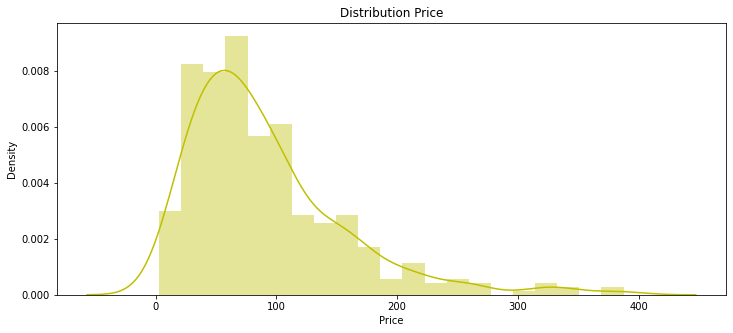

In [24]:
 #distribution of price
train_pd=train.toPandas()
pl.figure(figsize=(12,5))
pl.title("Distribution Price")
ax = sns.distplot(train_pd["Price"], color = 'y')

The boxplot below shows the spread of the values of `Price` for each sector. It appears that the health care sector has the greatest variance and telecommunication services has the least variance. The materials sector has the highest median and the highest value for `Price` in the data set.  

<AxesSubplot:xlabel='Sector', ylabel='Price'>

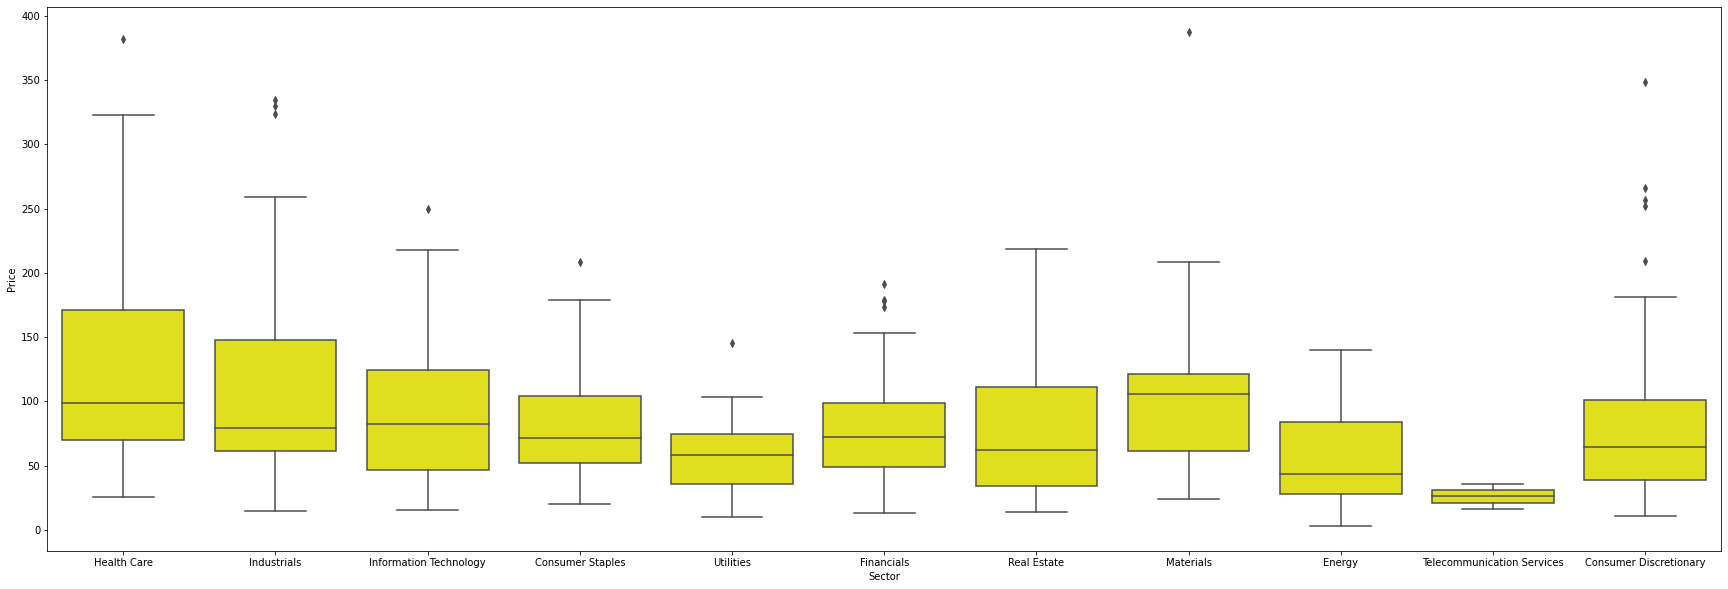

In [76]:
# boxplot of price 
fig, ax = plt.subplots(1, 1, figsize=(30,10))
sns.boxplot(x='Sector',y='Price',data=train.toPandas(),color='yellow')

In addition, we would like to view the proportion of data within each sector, so we created the pie chart below. As discovered previously by numeric means, the most common sectors are Consumer Discretionary, Industrials, Financials, and Information Technology.  

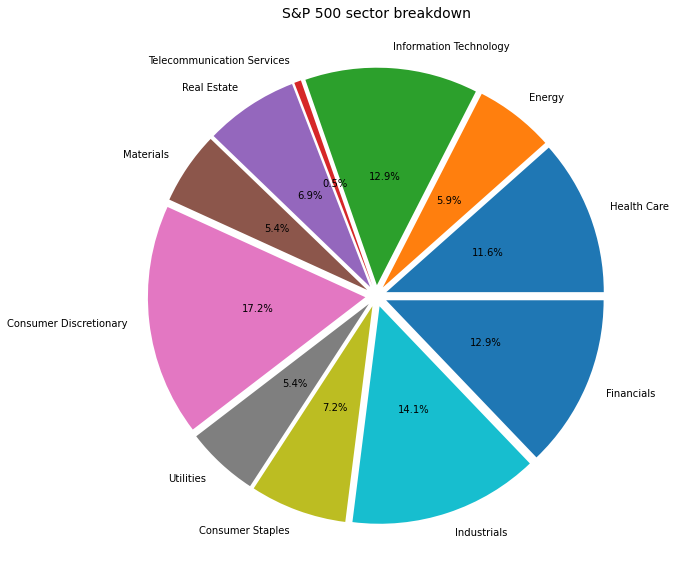

In [82]:
#find company volumn for each Sector
#pie chart
#sparksql to pd
pie1_pd=pie1.toPandas()
type(pie1_pd)
sector_names = list(pie1_pd['Sector'])
sector_values = list(pie1_pd['count']) 

pie, ax = plt.subplots(figsize=[15,10])
plt.pie(x=sector_values, autopct="%.1f%%", explode=[0.05]*len(sector_values), labels=sector_names, pctdistance=0.5)
plt.title("S&P 500 sector breakdown", fontsize=14);
pie.savefig("DeliveryPieChart.png")

Relationships between `Price` and other numeric variables are of interest as well. The graph below plots `Price` as a function of `Earnings/Share`, colored by `Sector`. It appears that `Price` and `Earnings/Share` may have a weak/medium positive relationship, although the variance does not appear constant.  

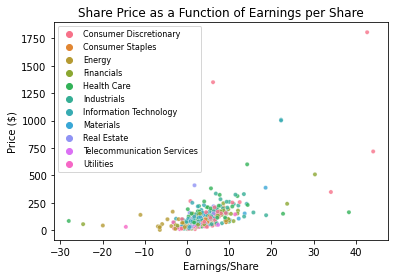

In [114]:
# price vs. earnings per share plot by sector
findata_pd=findata.toPandas()

findata_pd.Sector = findata_pd.Sector.astype('category')

plt.xlabel("Earnings/Share")
plt.ylabel("Price ($)")
plt.title("Share Price as a Function of Earnings per Share")

sns.scatterplot(x = "Earnings/Share", y = "Price", hue = "Sector", data = findata_pd,
               alpha = 0.8, s = 18)
    
plt.legend(loc = 'upper left', fontsize = 8)

We can also view the mean for each numeric variable grouped by `Sector`, which shows how the sectors differ based on metric.  

In [20]:
# View mean Price, Price/Earnings, Earnings/Share, and EBITDA for each sector
findata.groupBy('Sector').avg().to_pandas_on_spark()

,Sector,avg(Price),avg(Price/Earnings),avg(Dividend Yield),avg(Earnings/Share),avg(52 Week Low),avg(52 Week High),avg(Market Cap),avg(EBITDA),avg(Price/Sales),avg(Price/Book),avg(Consumer Discretionary),avg(Consumer Staples),avg(Energy),avg(Financials),avg(Health Care),avg(Industrials),avg(Information Technology),avg(Materials),avg(Real Estate),avg(Telecommunication Services),avg(Utilities)
0,Health Care,132.515738,NaN,0.917243,4.340492,160.758534,103.719253,5.318622e+10,3.657468e+09,4.827239,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Energy,57.887500,38.559063,2.014452,-1.648438,72.589687,48.141234,4.241607e+10,4.438905e+09,3.689595,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Information Technology,119.242857,37.179857,1.228494,3.110000,138.778641,91.891416,9.610175e+10,6.161996e+09,5.880142,10.873571,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Telecommunication Services,33.603333,11.190000,7.567797,4.426667,41.693333,29.503667,1.510141e+11,3.365833e+10,1.511056,3.716667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Real Estate,88.712727,22.459091,3.894758,2.391212,110.550455,82.878088,1.894896e+10,1.384265e+09,9.962681,6.004848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,Materials,102.386800,20.542400,1.737976,4.932000,118.038852,85.583248,2.769200e+10,2.284348e+09,2.876093,4.788800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,Consumer Discretionary,124.034524,NaN,1.572412,4.879048,146.931427,96.092364,3.825670e+10,3.501797e+09,2.275769,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Utilities,55.194643,16.846429,3.759224,2.014643,68.497321,52.802321,2.184402e+10,3.485105e+09,2.561081,2.106786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,Consumer Staples,79.764118,21.963235,2.433391,3.659412,92.832285,68.929441,6.138459e+10,5.291986e+09,2.869688,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Industrials,116.887612,21.494328,1.479392,5.344030,134.579476,90.837024,3.599313e+10,3.063030e+09,2.573401,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now, we want to examine `EBITDA` as it relates to `Sector` and `Price`, since `EBITDA` is often used as a proxy to determine the profitability of a company. First, we'll create a categorical version of the `Price` variable with levels low, medium, and high. The new data set with the `Price_cat` variable is outputted below.  

In [21]:
# Create categorical version of Price variable with levels "Low" "Medium" and "High" based on quantiles above

from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import *

def categorizer(price):
    if price < 46.25:
        return "Low"
    elif price < 116.54:
        return "Mid"
    else:
        return "High"
    
pricecat_udf = udf(categorizer, StringType())
fintrain = train.withColumn("Price_cat", pricecat_udf("Price")).to_pandas_on_spark()
fintrain.head()

,Symbol,Name,Sector,Price,Price_Earnings,Dividend_Yield,Earnings_Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price_Sales,Price_Book,SEC_Filings,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Industrials,Information_Technology,Materials,Real_Estate,Telecommunication_Services,Utilities,Price_cat
0,A,Agilent Technologies Inc,Health Care,65.05,27.45,0.875698,2.10,75.00,49.23,2.198461e+10,1.094000e+09,6.493563,4.56,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0,Mid
1,AAL,American Airlines Group,Industrials,48.60,9.92,0.778210,3.91,59.08,39.21,2.459485e+10,5.761000e+09,0.580226,6.03,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,1,0,0,0,0,0,Mid
2,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.20,180.10,131.12,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,0,1,0,0,0,0,High
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.05,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0,Mid
4,ABC,AmerisourceBergen Corp,Health Care,91.55,15.54,1.613246,1.64,106.27,71.90,2.058770e+10,9.918840e+08,0.173970,9.73,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0,Mid


Using the new categorical variable, the desired table is created. From the table, it appears that the relationship between `Price` and `EBITDA` may depend on `Sector`.  

In [22]:
# create pivot table returning mean EBITDA for each Sector/Price Level

fintrain.pivot_table(index = ["Sector"], columns = 'Price_cat', values = "EBITDA", aggfunc = "mean")

Price_cat,High,Low,Mid
Sector,,,
Health Care,2.818185e+09,5.465789e+09,3.401114e+09
Energy,2.151190e+09,1.197934e+09,9.521789e+09
Information Technology,7.834127e+09,6.086267e+09,4.043457e+09
Telecommunication Services,NaN,2.761500e+10,NaN
Real Estate,2.539633e+09,1.137779e+09,1.075044e+09
Materials,2.214919e+09,1.240200e+09,2.539423e+09
Consumer Discretionary,4.320324e+09,4.363204e+09,2.748197e+09
Utilities,9.018000e+09,2.696450e+09,3.855309e+09
Consumer Staples,2.567267e+09,2.460272e+09,6.760135e+09


Finally, we'll create a correlation matrix between the all numeric variables. This will assist us in determining which variables to include in our model. According to the matrix, `52_Week_Low` and `52_Week_High` are both strongly correlated with `Price`, but they are also highly correlated with each other. Therefore, we'll only choose one, `52_Week_Low`, to include in our models.  

In [25]:
# Correlation analysis of our new data frame
train_pd.iloc[:,:].corr().style.background_gradient(cmap='Purples').format("{:.3f}")

,Price,Price_Earnings,Dividend_Yield,Earnings_Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price_Sales,Price_Book,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Industrials,Information_Technology,Materials,Real_Estate,Telecommunication_Services,Utilities
Price,1.000,0.195,-0.298,0.573,0.979,0.962,0.150,0.067,0.235,0.084,-0.047,-0.038,-0.140,-0.067,0.196,0.140,-0.000,0.067,-0.045,-0.072,-0.119
Price_Earnings,0.195,1.000,-0.197,0.039,0.190,0.148,0.036,-0.032,0.240,0.022,-0.017,-0.015,0.124,-0.073,0.041,-0.033,0.100,0.006,-0.063,-0.031,-0.057
Dividend_Yield,-0.298,-0.197,1.000,-0.046,-0.289,-0.235,0.046,0.154,-0.057,0.064,-0.078,0.091,-0.007,-0.006,-0.234,-0.104,-0.152,-0.038,0.358,0.336,0.288
Earnings_Share,0.573,0.039,-0.046,1.000,0.542,0.579,0.146,0.194,-0.052,0.050,0.072,0.029,-0.319,0.015,0.049,0.164,-0.088,0.095,-0.044,-0.007,-0.078
52_Week_Low,0.979,0.190,-0.289,0.542,1.000,0.969,0.125,0.054,0.232,0.079,-0.030,-0.045,-0.121,-0.083,0.206,0.122,-0.018,0.055,-0.026,-0.067,-0.106
52_Week_High,0.962,0.148,-0.235,0.579,0.969,1.000,0.127,0.071,0.209,0.082,-0.062,-0.021,-0.131,-0.064,0.187,0.118,-0.056,0.085,0.017,-0.073,-0.083
Market_Cap,0.150,0.036,0.046,0.146,0.125,0.127,1.000,0.788,0.054,0.099,-0.078,0.032,-0.004,0.062,0.020,-0.048,0.171,-0.051,-0.093,0.074,-0.069
EBITDA,0.067,-0.032,0.154,0.194,0.054,0.071,0.788,1.000,-0.065,0.077,0.014,0.057,0.054,-0.166,0.000,-0.027,0.125,-0.044,-0.081,0.258,0.009
Price_Sales,0.235,0.240,-0.057,-0.052,0.232,0.209,0.054,-0.065,1.000,0.018,-0.217,-0.097,-0.014,-0.048,0.090,-0.169,0.218,-0.063,0.490,-0.051,-0.094
Price_Book,0.084,0.022,0.064,0.050,0.079,0.082,0.099,0.077,0.018,1.000,0.004,0.192,-0.032,-0.037,-0.008,-0.007,-0.018,-0.021,-0.030,-0.010,-0.032


## The Machine Learning Process  



### Model 1: Multiple Linear Regression  

In [ ]:
#stock price prediction 



In [26]:
sqlTrans = SQLTransformer(
    statement =  "Select Price_Earnings, Dividend_Yield, Market_Cap, 52_Week_Low, EBITDA, Price_Sales, Price_Book, Price as label FROM __THIS__;"
)

In [27]:
sqlTrans.transform(train).show(5)

+--------------+--------------+---------------+-----------+---------+-----------+----------+------+
|Price_Earnings|Dividend_Yield|     Market_Cap|52_Week_Low|   EBITDA|Price_Sales|Price_Book| label|
+--------------+--------------+---------------+-----------+---------+-----------+----------+------+
|         27.45|     0.8756979|2.1984606918E10|       75.0|  1.094E9|   6.493563|      4.56| 65.05|
|          9.92|     0.7782101|2.4594852352E10|      59.08|  5.761E9| 0.58022565|      6.03|  48.6|
|         16.86|     1.5795412|     8.09508E11|      180.1|7.9386E10|  3.4586093|      5.66|155.15|
|         19.41|     2.4995599|     1.81386E11|     125.86| 1.031E10|   6.291571|     26.14|108.48|
|         15.54|     1.6132456|2.0587704101E10|     106.27|9.91884E8| 0.17396984|      9.73| 91.55|
+--------------+--------------+---------------+-----------+---------+-----------+----------+------+
only showing top 5 rows



In [15]:
#put 6 predictors into feature
assembler = VectorAssembler(inputCols = ["Price_Earnings", "Dividend_Yield", "Market_Cap", "EBITDA", "Price_Sales", "Price_Book"], outputCol = "features", handleInvalid = 'keep')

In [16]:
#transform x(feature) and y(label) for spark model
assembler.transform(
    sqlTrans.transform(train)
).select("label", "features").show(3)

+------+--------------------+
| label|            features|
+------+--------------------+
| 65.05|[27.45,0.8756979,...|
|  48.6|[9.92,0.7782101,2...|
|155.15|[16.86,1.5795412,...|
+------+--------------------+
only showing top 3 rows



In [17]:
#Model1 is linear regression ( no penalty)
Model1 = LinearRegression(regParam = 0, elasticNetParam = 0)

In [18]:
#Train the Model1
TrainModel1 = Model1.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label", "features")
)

In [19]:
# predictive model1
print("Intercept: %s" % str(TrainModel1.intercept), "Coefficients: %s" % str(TrainModel1.coefficients))

Intercept: 95.24256754257897 Coefficients: [0.02197583893119779,-18.684565615197364,4.184345907909309e-10,-1.1711505757568957e-09,6.337291652641095,0.09799930867510238]


In [20]:
# Check Training RMSE
trainingSummary = TrainModel1.summary
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)



C:\Users\autum\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------------+
|          residuals|
+-------------------+
| -63.95013016251211|
| -40.13238370115828|
|-179.17612004233726|
|  -46.7427641737835|
|  16.59972827566395|
+-------------------+
only showing top 5 rows

RMSE: 117.140624
r2: 0.152303


In [21]:
# using Traning set to predict training set Y
preds = TrainModel1.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label", "features")
)

In [22]:
preds.show(5)# big difference

+------+--------------------+------------------+
| label|            features|        prediction|
+------+--------------------+------------------+
| 65.05|[27.45,0.8756979,...| 129.0001301625121|
|  48.6|[9.92,0.7782101,2...| 88.73238370115828|
|155.15|[16.86,1.5795412,...|334.32612004233727|
|108.48|[19.41,2.4995599,...| 155.2227641737835|
| 91.55|[15.54,1.6132456,...| 74.95027172433605|
+------+--------------------+------------------+
only showing top 5 rows



In [23]:
# Use CV to tune the parameter

CVTrainModel1 = LinearRegression()

In [24]:
#Grid the parameter
paramGrid = ParamGridBuilder() \
    .addGrid(CVTrainModel1.regParam, [0, 0.01, 0.05]) \
    .addGrid(CVTrainModel1.fitIntercept, [False, True]) \
    .addGrid(CVTrainModel1.elasticNetParam, [0, 0.05, 0.1]) \
    .build()

In [25]:
# Use CV to evaluate the RMSE to find min RMSE ( find the best model from 18 models)
crossval = CrossValidator(estimator = CVTrainModel1,
                          estimatorParamMaps = paramGrid,
                          evaluator = RegressionEvaluator(metricName='rmse'),
                          numFolds=5)

In [26]:
# put training set to fit the model
CVModel = crossval.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label", "features")
)

In [27]:
# 18 models output
list(zip(CVModel.avgMetrics, paramGrid))

[(141.37120943543943,
  {Param(parent='LinearRegression_224ab332f3de', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_224ab332f3de', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_224ab332f3de', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (141.37120943543943,
  {Param(parent='LinearRegression_224ab332f3de', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_224ab332f3de', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_224ab332f3de', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.05}),
 (141.37120943543943,
  {Param(parent='LinearRegression

In [28]:
# find the min RMSE as best Model
print(CVModel.bestModel._java_obj.intercept(), CVModel.bestModel._java_obj.coefficients())

95.24357419805428 [0.022035541124090965,-18.678545885444372,4.1772766320745314E-10,-1.1634375178352416E-9,6.33566313001061,0.09790231525547644]


In [29]:
CVModel.transform(test).show(5)

IllegalArgumentException: features does not exist. Available: Symbol, Name, Sector, Price, Price_Earnings, Dividend_Yield, Earnings_Share, 52_Week_Low, 52_Week_High, Market_Cap, EBITDA, Price_Sales, Price_Book, SEC_Filings, Consumer_Discretionary, Consumer_Staples, Energy, Financials, Health_Care, Industrials, Information_Technology, Materials, Real_Estate, Telecommunication_Services, Utilities

In [ ]:
# use the best model to predict

In [ ]:
test_error = RegressionEvaluator().evaluate(CVModel.transform(test))
print(test_error)

## Model 2

## Model 3

In [9]:
rf = RandomForestRegressor(labelCol = "label", featuresCol = "features")

In [10]:
sqlTrans3 = SQLTransformer(
    statement = "SELECT Price_Earnings, Dividend_Yield, Market_Cap, EBITDA, Price_Sales, Price_Book, Price as label FROM __THIS__;"
)
    

In [11]:
assembler3 = VectorAssembler(inputCols = ["Price_Earnings", "Dividend_Yield", "Market_Cap", "EBITDA", "Price_Sales", "Price_Book"], outputCol = "features", handleInvalid = 'keep')

In [12]:
pipeline3 = Pipeline(stages = [sqlTrans3, assembler3, rf])

In [13]:
rfevaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "rmse")

paramGrid3 = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.maxBins, [5, 10, 20]) \
    .addGrid(rf.numTrees, [5, 20, 50]) \
    .build()

crossval3 = CrossValidator(estimator = pipeline3,
                          estimatorParamMaps = paramGrid3,
                          evaluator = rfevaluator,
                          numFolds = 5)

In [14]:
rfModel = crossval3.fit(train)

Py4JJavaError: An error occurred while calling o514.cache.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Long.valueOf(Unknown Source)
	at scala.runtime.BoxesRunTime.boxToLong(BoxesRunTime.java:71)
	at org.apache.spark.sql.catalyst.expressions.ExprId.hashCode(namedExpressions.scala:50)
	at org.apache.spark.sql.catalyst.expressions.AttributeReference.hashCode(namedExpressions.scala:287)
	at scala.runtime.Statics.anyHash(Statics.java:122)
	at scala.collection.immutable.HashSet.elemHashCode(HashSet.scala:179)
	at scala.collection.immutable.HashSet.computeHash(HashSet.scala:188)
	at scala.collection.immutable.HashSet.contains(HashSet.scala:58)
	at scala.collection.GenSetLike.apply(GenSetLike.scala:48)
	at scala.collection.GenSetLike.apply$(GenSetLike.scala:48)
	at scala.collection.AbstractSet.apply(Set.scala:51)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChild$1(TreeNode.scala:270)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$withNewChildren$4(TreeNode.scala:283)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$Lambda$1418/206241495.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.TraversableLike$$Lambda$32/254749889.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$withNewChildren$2(TreeNode.scala:283)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$Lambda$1417/311301772.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:244)
	at org.apache.spark.sql.catalyst.trees.TreeNode.withNewChildren(TreeNode.scala:276)
	at org.apache.spark.sql.catalyst.expressions.Expression.canonicalized$lzycompute(Expression.scala:230)
	at org.apache.spark.sql.catalyst.expressions.Expression.canonicalized(Expression.scala:228)
	at org.apache.spark.sql.catalyst.expressions.ExpressionSet.add(ExpressionSet.scala:69)
	at org.apache.spark.sql.catalyst.expressions.ExpressionSet.$anonfun$map$1(ExpressionSet.scala:122)
	at org.apache.spark.sql.catalyst.expressions.ExpressionSet.$anonfun$map$1$adapted(ExpressionSet.scala:122)
	at org.apache.spark.sql.catalyst.expressions.ExpressionSet$$Lambda$2776/422687987.apply(Unknown Source)


In [156]:
list(zip(rfModel.avgMetrics, paramGrid))

[(57.75005131057732,
  {Param(parent='RandomForestRegressor_91e759399035', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='RandomForestRegressor_91e759399035', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 5,
   Param(parent='RandomForestRegressor_91e759399035', name='numTrees', doc='Number of trees to train (>= 1).'): 5}),
 (56.15439154959401,
  {Param(parent='RandomForestRegressor_91e759399035', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='RandomForestRegressor_91e759399035', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorica

In [140]:
rfModel.transform(test).show(5)

AnalysisException: cannot resolve '`Price_Earnings`' given input columns: [sqltransformer_fb2b1da37440_5e8dfe1183f9.52 Week High, sqltransformer_fb2b1da37440_5e8dfe1183f9.52 Week Low, sqltransformer_fb2b1da37440_5e8dfe1183f9.Consumer Discretionary, sqltransformer_fb2b1da37440_5e8dfe1183f9.Consumer Staples, sqltransformer_fb2b1da37440_5e8dfe1183f9.Dividend Yield, sqltransformer_fb2b1da37440_5e8dfe1183f9.EBITDA, sqltransformer_fb2b1da37440_5e8dfe1183f9.Earnings/Share, sqltransformer_fb2b1da37440_5e8dfe1183f9.Energy, sqltransformer_fb2b1da37440_5e8dfe1183f9.Financials, sqltransformer_fb2b1da37440_5e8dfe1183f9.Health Care, sqltransformer_fb2b1da37440_5e8dfe1183f9.Industrials, sqltransformer_fb2b1da37440_5e8dfe1183f9.Information Technology, sqltransformer_fb2b1da37440_5e8dfe1183f9.Market Cap, sqltransformer_fb2b1da37440_5e8dfe1183f9.Materials, sqltransformer_fb2b1da37440_5e8dfe1183f9.Name, sqltransformer_fb2b1da37440_5e8dfe1183f9.Price, sqltransformer_fb2b1da37440_5e8dfe1183f9.Price/Book, sqltransformer_fb2b1da37440_5e8dfe1183f9.Price/Earnings, sqltransformer_fb2b1da37440_5e8dfe1183f9.Price/Sales, sqltransformer_fb2b1da37440_5e8dfe1183f9.Real Estate, sqltransformer_fb2b1da37440_5e8dfe1183f9.SEC Filings, sqltransformer_fb2b1da37440_5e8dfe1183f9.Sector, sqltransformer_fb2b1da37440_5e8dfe1183f9.Symbol, sqltransformer_fb2b1da37440_5e8dfe1183f9.Telecommunication Services, sqltransformer_fb2b1da37440_5e8dfe1183f9.Utilities]; line 1 pos 7;
'Project ['Price_Earnings, 'Dividend_Yield, 'Market_Cap, EBITDA#453377, 'Price_Sales, 'Price_Book, Price#453370 AS label#453417]
+- SubqueryAlias sqltransformer_fb2b1da37440_5e8dfe1183f9
   +- LogicalRDD [Symbol#453367, Name#453368, Sector#453369, Price#453370, Price/Earnings#453371, Dividend Yield#453372, Earnings/Share#453373, 52 Week Low#453374, 52 Week High#453375, Market Cap#453376, EBITDA#453377, Price/Sales#453378, Price/Book#453379, SEC Filings#453380, Consumer Discretionary#453381L, Consumer Staples#453382L, Energy#453383L, Financials#453384L, Health Care#453385L, Industrials#453386L, Information Technology#453387L, Materials#453388L, Real Estate#453389L, Telecommunication Services#453390L, Utilities#453391L], false


In [ ]:
rf_test_error = rfevaluator.evaluate(rfModel.transform(test))
print(rf_test_error)